# Hyunwoo Moon's Amazing Code

## Import

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [2]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()

    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]

    
    # 픽셀값이 1,2,3인 픽셀 삭제
    result = []
    for i in range(1, len(runs), 2):  # 짝수번째 인덱스만 접근
        if runs[i] not in [1, 2, 3]:
            result.extend([runs[i-1], runs[i]])  # 해당 인덱스와 그 전 인덱스를 추가
    
    return ' '.join(str(x) for x in result)

## Custom Dataset

In [3]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Data Loader

In [4]:
transform = A.Compose(
    [
        # 이미지 크기 조정
        A.Resize(224, 224),

        # 이미지 품질 개선을 위한 전처리
        A.OneOf([
            # 이미지 날카로움 향상
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=True),

            # 가우시안 블러
            A.GaussianBlur(blur_limit=(3, 7), always_apply=True)
        ], p=0.5),

        # 명암 대비 조정과 밝기 조절
        A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), always_apply=True),

        # 색감 조정
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, always_apply=True),

        # 이미지를 텐서로 변환
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)

## Define Model

In [5]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   

        x = self.dconv_down4(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

# 깊은 U-Net 모델 정의
class DeepUNet(nn.Module):
    def __init__(self):
        super(DeepUNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        

        self.dconv_up4 = double_conv(1024 + 512, 512)
        self.dconv_up3 = double_conv(512 + 256, 256)
        self.dconv_up2 = double_conv(256 + 128, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        x = self.dconv_down5(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv4], dim=1)

        x = self.dconv_up4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out


## Select Model

In [6]:
# UNet / DeepUNet
select_model = 'UNet'    # 사용할 모델 선택

## Select Mode

In [7]:
# Nothing : -1 / Training : 0 / Inference : 1 / Traing & Inference : 2
mode = -1

## Model Train

In [8]:
if mode in [0,2]:
    # model 초기화
    if select_model == 'UNet':
        model = UNet().to(device)
    elif select_model == 'DeepUNet':
        model = DeepUNet().to(device)

    # loss function과 optimizer 정의
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 최적 모델 저장을 위한 변수 초기화
    best_val_loss = 1  # 최저 손실값을 저장할 변수
    patience = 2  # 성능이 개선되지 않을 때 학습 종료 기다리는 횟수

    # training loop
    for epoch in range(30):  # 최대 30에폭 동안 학습
        model.train()
        epoch_loss = 0
        for images, masks in tqdm(dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

        # 유의미한 성능 개선이 있을 경우
        if best_val_loss - epoch_loss/len(dataloader) > 0.0001:   
            patience = 1
            best_val_loss = epoch_loss/len(dataloader)    # 최상의 Loss값 갱신
            torch.save(model, f'./model(' + select_model + ').pt')   # 최적의 모델 갱신

        # 미미한 성능 개선이 있을 경우 혹은 성능 개선이 없을 경우    
        else:
            patience = patience - 1 
            # 미미한 성능 개선이 있을 경우
            if (best_val_loss - epoch_loss/len(dataloader) <= 0.0001) and (best_val_loss - epoch_loss/len(dataloader) > 0):
                best_val_loss = epoch_loss/len(dataloader)    # 최상의 Loss값 갱신
                torch.save(model, f'./model(' + select_model + ').pt')   # 최적의 모델 갱신
            # 유의미한 성능 개선 3번 연속 없을 경우 학습 종료
            if patience < 0:
                break

    print('Training is Ended!! Best Loss: ' + str(best_val_loss))


## Inference

In [9]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

In [10]:
if mode in [1,2]:
    model = torch.load('model(' + select_model + ').pt')
    print('Inference by model(' + select_model + ').pt')

    threshold = 0.45   # 임계값 / Original Threshold = 0.35

    with torch.no_grad():
        model.eval()
        result = []
        for images in tqdm(test_dataloader):
            images = images.float().to(device)

            outputs = model(images)
            masks = torch.sigmoid(outputs).cpu().numpy()
            masks = np.squeeze(masks, axis=1)
            masks = (masks > threshold).astype(np.uint8)

            for i in range(len(images)):
                mask_rle = rle_encode(masks[i])
                if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)

## Submission

In [11]:
if mode in [1,2]:
    submit = pd.read_csv('./sample_submission.csv')
    submit['mask_rle'] = result
    
    temp = './submit(' + select_model + ' ' + str(threshold) + ').csv'
    submit.to_csv(temp, index=False)

In [12]:
#temp = './submit(' + select_model + ' ' + str(threshold) + ').csv'
#submit.to_csv(temp, index=False)

## Visualization

TEST_00000


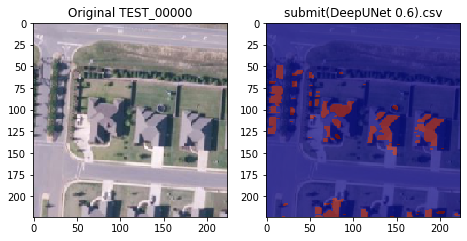

TEST_00001


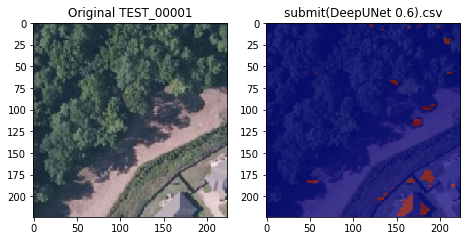

TEST_00002


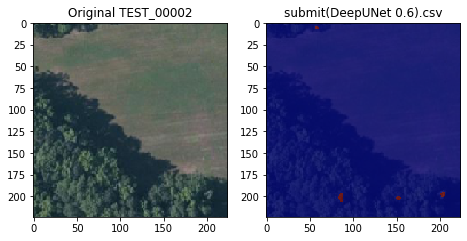

TEST_00003


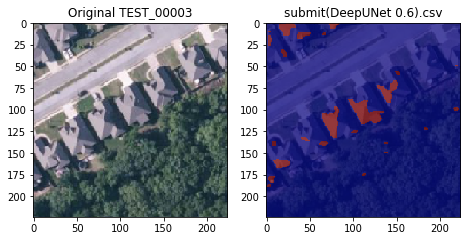

TEST_00004


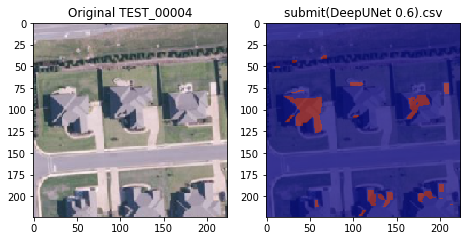

TEST_00005


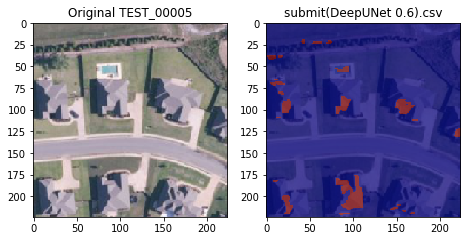

TEST_00006


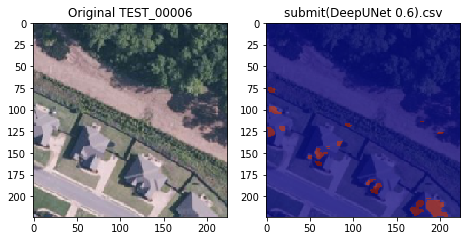

TEST_00007


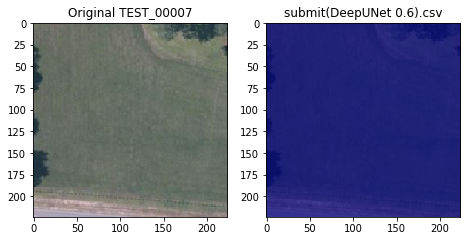

TEST_00008


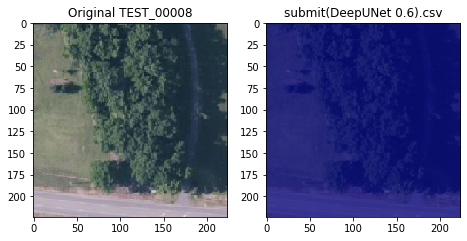

TEST_00009


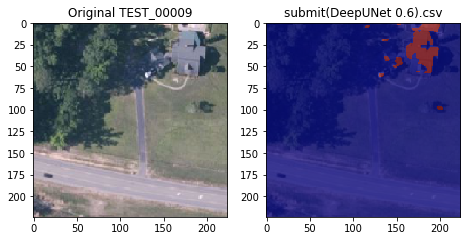

TEST_00010


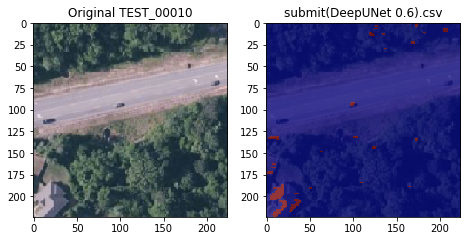

TEST_00011


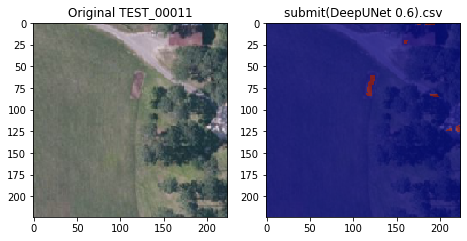

TEST_00012


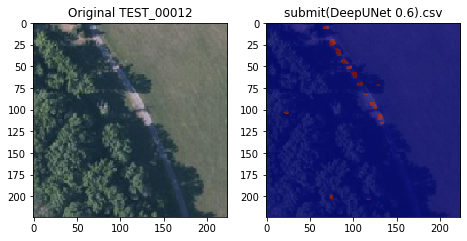

TEST_00013


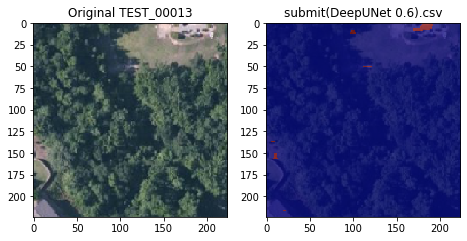

TEST_00014


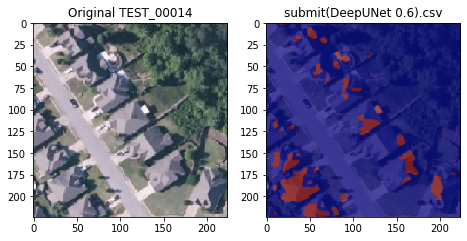

TEST_00015


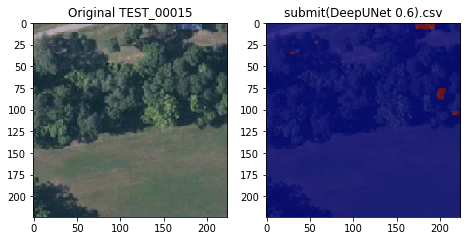

TEST_00016


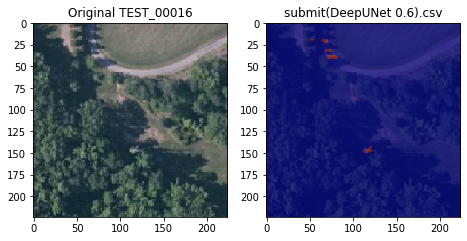

TEST_00017


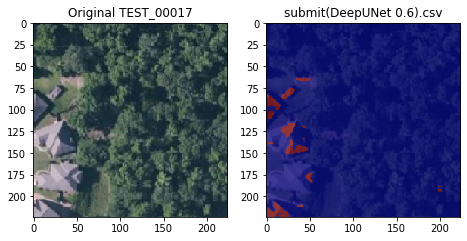

TEST_00018


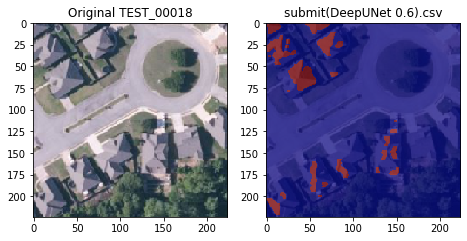

TEST_00019


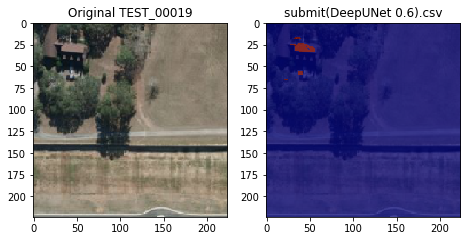

TEST_00020


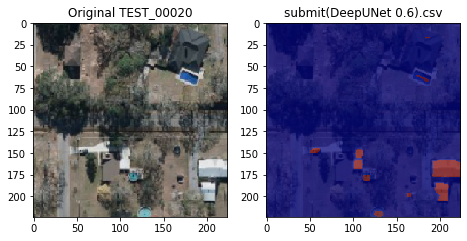

TEST_00021


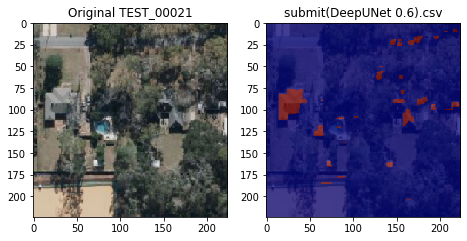

TEST_00022


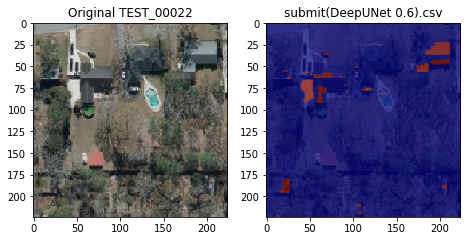

TEST_00023


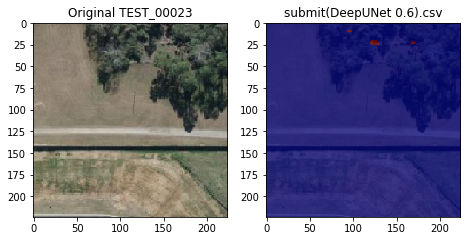

TEST_00024


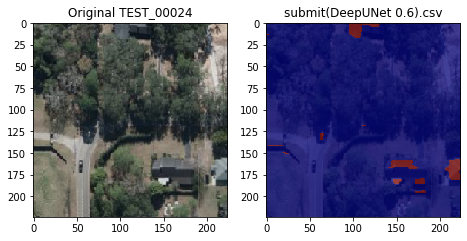

TEST_00025


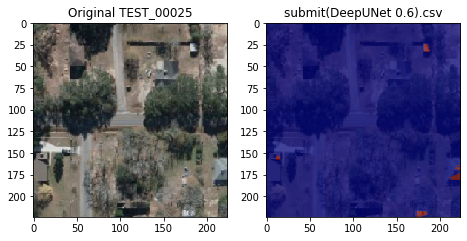

TEST_00026


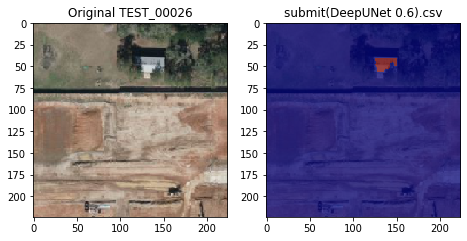

TEST_00027


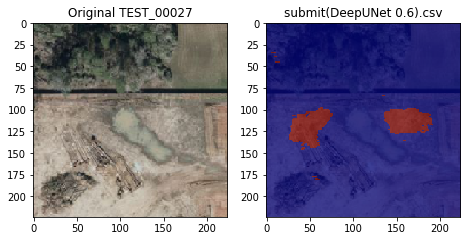

TEST_00028


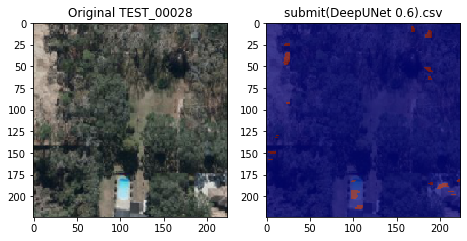

TEST_00029


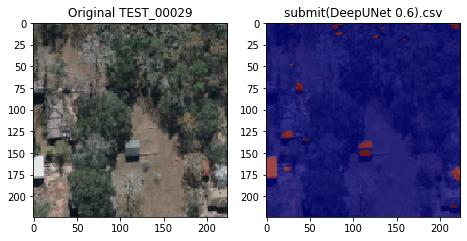

TEST_00030


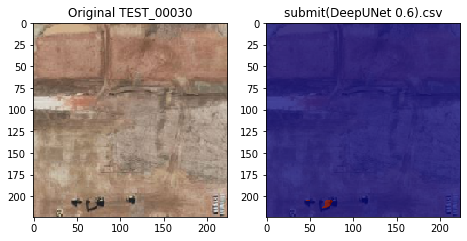

TEST_00031


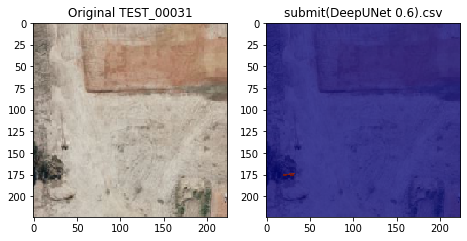

In [ ]:
submit_csv1 = ''     
submit_csv2 = ''
submit_csv3 = ''

def visual(image_idx, submit_csv1, submit_csv2, submit_csv3):
# Decoding - submit_csv1       
    # CSV 파일 읽기
    df = pd.read_csv(submit_csv1, header=None)

    # 이미지 파일 이름과 마스크 정보 파싱
    image_names = df[0].values
    mask_info = df[1].values

    image_name = image_names[image_idx + 1]
    mask_str = mask_info[image_idx + 1]
    print(image_names[image_idx + 1])

    # 이미지 파일과 마스크 정보 출력
    image = cv2.imread('./test_img/' + image_name + '.png')
    mask_decoded1 = rle_decode(mask_str, shape=(224, 224))
    
# Decoding - submit_csv2 
    if submit_csv2 != '':
        # CSV 파일 읽기
        df = pd.read_csv(submit_csv2, header=None)

        # 이미지 파일 이름과 마스크 정보 파싱
        image_names = df[0].values
        mask_info = df[1].values

        image_name = image_names[image_idx + 1]
        mask_str = mask_info[image_idx + 1]

        # 이미지 파일과 마스크 정보 출력
        image = cv2.imread('./test_img/' + image_name + '.png')
        mask_decoded2 = rle_decode(mask_str, shape=(224, 224))
        
# Decoding - submit_csv3   
    if submit_csv3 != '':
        # CSV 파일 읽기
        df = pd.read_csv(submit_csv3, header=None)

        # 이미지 파일 이름과 마스크 정보 파싱
        image_names = df[0].values
        mask_info = df[1].values

        image_name = image_names[image_idx + 1]
        mask_str = mask_info[image_idx + 1]

        # 이미지 파일과 마스크 정보 출력
        image = cv2.imread('./test_img/' + image_name + '.png')
        mask_decoded3 = rle_decode(mask_str, shape=(224, 224))

# 시각화 - original image
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original ' + image_name)
    
# 시각화 - submit_csv1
    plt.subplot(1, 4, 2)
    # 디코딩된 값을 이미지 위에 표시
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(mask_decoded1, cmap='jet', alpha=0.7)  # alpha 값을 조정하여 투명도 조절
    plt.title(submit_csv1)
    
# 시각화 - submit_csv2
    if submit_csv2 != '':
        plt.subplot(1, 4, 3)
        # 디코딩된 값을 이미지 위에 표시
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.imshow(mask_decoded2, cmap='jet', alpha=0.7)  # alpha 값을 조정하여 투명도 조절
        plt.title(submit_csv2)
        
# 시각화 - submit_csv3
    if submit_csv3 != '':
        plt.subplot(1, 4, 4)
        # 디코딩된 값을 이미지 위에 표시
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.imshow(mask_decoded3, cmap='jet', alpha=0.7)  # alpha 값을 조정하여 투명도 조절
        plt.title(submit_csv3)
              
    plt.show()
    
    

submit_csv1 = 'submit(DeepUNet 0.6).csv'
submit_csv2
submit_csv3
        
for i in range(0, 101):
    visual(i, submit_csv1, submit_csv2, submit_csv3)